# Model evaluation using Sidekick

Use the Deployment API of the Peltarion platform via Sidekick to get predictions on samples and evaluate the performance of the deployed model in more detail.

**Note**: This notebook requires installation of Sidekick. For more information about this package, see:
https://github.com/Peltarion/sidekick

In [1]:
from glob import glob
import itertools
import os
import operator
import resource

from IPython.display import display, Image
import pandas as pd
from PIL import Image
from tqdm import tqdm
import sidekick
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## Setup

### Paths

In [2]:
#preprocessed dataset
dataset_path = './fruits-360/Test'

### Client to deployment

In [3]:
#Update the URL and token
deployment_url = 'https://a.peltarion.com/deployment/5ef499e8-9a7d-4489-89fe-f6969dd99cee/forward'
deployment_token = '8fba4d99-fc55-4d08-b4f9-41bdf3fb7c99'

client = sidekick.Deployment(
    url=deployment_url,
    token=deployment_token,
    dtypes_in={'image': 'Image (100x100x3)'},
    dtypes_out={'class': 'Categorical (103)'}
)

### Helper functions

In [4]:
def get_max_score(pred):
    max_key = 'None'
    max_score = 0
    dict = pred['class'].items()
    for key,score in dict:
        if score >= max_score:        
            max_key = key
            max_score = score
    return (max_key, max_score)


def get_image(path):
    im = Image.open(path)
    new_im = im.copy()
    new_im.format = 'jpeg'
    im.close()
    return new_im

### Progress bars for pandas

In [5]:
tqdm.pandas()

## Create test dataframe - ground truth

In [6]:
images_rel_path = glob(dataset_path + '/*/*.jpg') + glob(dataset_path + '/*/*.png')
print("Images found: ", len(images_rel_path))

Images found:  17845


In [7]:
df = pd.DataFrame({'image': images_rel_path})
df['class'] = df['image'].progress_apply(lambda path: os.path.basename(os.path.dirname(path)))
df = df.sample(frac=1).reset_index(drop=True)
df.head()

100%|██████████| 17845/17845 [00:00<00:00, 273285.22it/s]


,image,class
0,./fruits-360/Test/Grape White 2/1_100.jpg,Grape White 2
1,./fruits-360/Test/Apple Red 1/r_63_100.jpg,Apple Red 1
2,./fruits-360/Test/Apple Braeburn/74_100.jpg,Apple Braeburn
3,./fruits-360/Test/Maracuja/96_100.jpg,Maracuja
4,./fruits-360/Test/Salak/135_100.jpg,Salak


## Single  predictions

In [8]:
im_path_list = iter(list(df['image']))

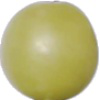

('Grape White 2', 0.9997408)


In [9]:
im_path = next(im_path_list)
im = Image.open(im_path)
display(im)
pred = client.predict(image=im)
print(get_max_score(pred))

## Multiple predictions

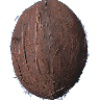

Ground truth: Cocos
Prediction: Cocos


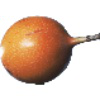

Ground truth: Granadilla
Prediction: Granadilla


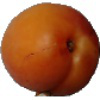

Ground truth: Apricot
Prediction: Nectarine


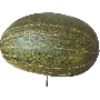

Ground truth: Melon Piel de Sapo
Prediction: Melon Piel de Sapo


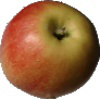

Ground truth: Apple Red 2
Prediction: Apple Red 2


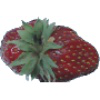

Ground truth: Strawberry Wedge
Prediction: Strawberry Wedge


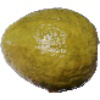

Ground truth: Guava
Prediction: Guava


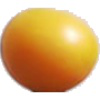

Ground truth: Cherry Wax Yellow
Prediction: Cherry Wax Yellow


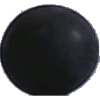

Ground truth: Grape Blue
Prediction: Grape Blue


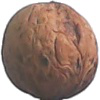

Ground truth: Walnut
Prediction: Walnut


In [10]:
rows = df.sample(n=10)
for i, row in rows.iterrows():
    im = Image.open(row['image'])    
    display(im)
    pred = client.predict(image=im)
    print('Ground truth: {}\nPrediction: {}'.format(row['class'], get_max_score(pred)[0]))

## Worst misclassified

Copy the image URLs to a new column.
Create a new column that contains the actual images.

In [11]:
eval_df = df.copy()
eval_df['image_url'] = eval_df['image']
eval_df['image'] = eval_df['image'].progress_apply(lambda path: get_image(path))
predictions = client.predict_lazy(eval_df.to_dict('record'))

100%|██████████| 17845/17845 [00:16<00:00, 1072.79it/s]


Get all the predictions and store these in a new column.

**Note**: This may take several minutes

In [12]:
pbar = tqdm(total=len(eval_df))
preds = []
for p in predictions:
    preds.append(p)
    pbar.update(1)
pbar.close()

100%|██████████| 17845/17845 [35:30<00:00,  8.38it/s] 


In [14]:
eval_df['pred'] = [p['class'] for p in preds]
eval_df.head(3)

,image,class,image_url,pred
0,<PIL.Image.Image image mode=RGB size=100x100 a...,Grape White 2,./fruits-360/Test/Grape White 2/1_100.jpg,"{'Apple Granny Smith': 6.000722e-19, 'Grapefru..."
1,<PIL.Image.Image image mode=RGB size=100x100 a...,Apple Red 1,./fruits-360/Test/Apple Red 1/r_63_100.jpg,"{'Apple Granny Smith': 1.6919832e-27, 'Grapefr..."
2,<PIL.Image.Image image mode=RGB size=100x100 a...,Apple Braeburn,./fruits-360/Test/Apple Braeburn/74_100.jpg,"{'Apple Granny Smith': 4.0987383e-18, 'Grapefr..."


Create new columns that contain the name of highest scoring class and the score.

In [15]:
dicts = eval_df['pred']
max_keys = []
max_scores = []

for i in dicts:
    max_val = max(i.items(), key=lambda k: k[1])     
    max_keys.append(max_val[0])
    max_scores.append(max_val[1])
eval_df['pred_class'] = max_keys
eval_df['pred_score'] = max_scores
eval_df.head(3)

,image,class,image_url,pred,pred_class,pred_score
0,<PIL.Image.Image image mode=RGB size=100x100 a...,Grape White 2,./fruits-360/Test/Grape White 2/1_100.jpg,"{'Apple Granny Smith': 6.000722e-19, 'Grapefru...",Grape White 2,0.999741
1,<PIL.Image.Image image mode=RGB size=100x100 a...,Apple Red 1,./fruits-360/Test/Apple Red 1/r_63_100.jpg,"{'Apple Granny Smith': 1.6919832e-27, 'Grapefr...",Apple Red 1,0.999354
2,<PIL.Image.Image image mode=RGB size=100x100 a...,Apple Braeburn,./fruits-360/Test/Apple Braeburn/74_100.jpg,"{'Apple Granny Smith': 4.0987383e-18, 'Grapefr...",Apple Braeburn,0.998991


Get the top-ten samples with the highest prediction score and incorrect label, i.e., the worst misclasified samples.

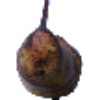

Ground truth: Pear Abate, Prediction: Granadilla, Score: 0.9999161


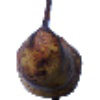

Ground truth: Pear Abate, Prediction: Granadilla, Score: 0.9995419


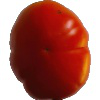

Ground truth: Tomato 1, Prediction: Tomato 3, Score: 0.99951494


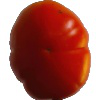

Ground truth: Tomato 1, Prediction: Tomato 3, Score: 0.9994886


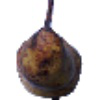

Ground truth: Pear Abate, Prediction: Granadilla, Score: 0.9993418


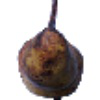

Ground truth: Pear Abate, Prediction: Granadilla, Score: 0.99863905


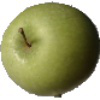

Ground truth: Apple Granny Smith, Prediction: Pear, Score: 0.998628


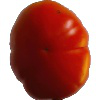

Ground truth: Tomato 1, Prediction: Tomato 3, Score: 0.99826247


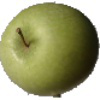

Ground truth: Apple Granny Smith, Prediction: Pear, Score: 0.9981713


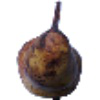

Ground truth: Pear Abate, Prediction: Granadilla, Score: 0.99802506


In [16]:
wrong_df = eval_df.loc[eval_df['class'] != eval_df['pred_class']]
wrong_df = wrong_df.sort_values(by=['pred_score'], ascending=False)
first_rows = wrong_df.head(10)
for i, row in first_rows.iterrows():
    display(row['image'])
    print('Ground truth: {}, Prediction: {}, Score: {}'.format(row['class'], row['pred_class'], row['pred_score']))

### Number of miclassified Apple Granny Smith

In [17]:
df_granny_smith = wrong_df.loc[df['class'] == 'Apple Granny Smith']
print('Number of misclasified Apple Granny Smith: {}'.format(df_granny_smith.shape[0]))

Number of misclasified Apple Granny Smith: 39


### View all misclassified samples in class Apple Granny Smith

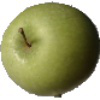

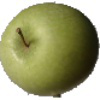

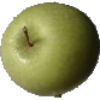

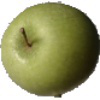

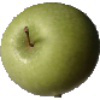

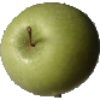

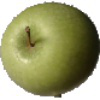

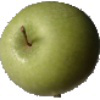

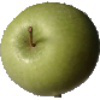

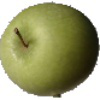

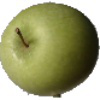

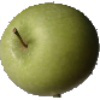

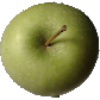

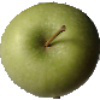

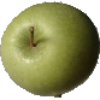

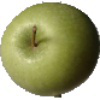

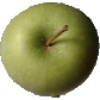

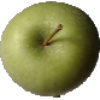

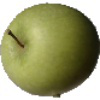

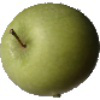

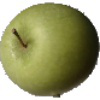

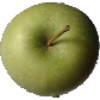

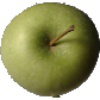

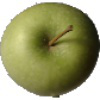

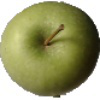

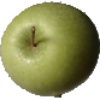

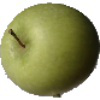

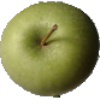

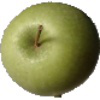

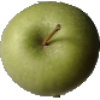

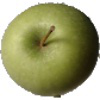

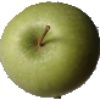

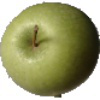

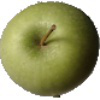

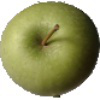

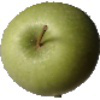

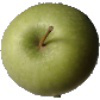

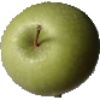

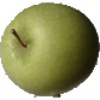

In [18]:
for i, row in df_granny_smith.iterrows():
    im = row['image']
    display(im)

## Classification report

In [19]:
print(classification_report(y_pred=eval_df['pred_class'], y_true=eval_df['class']))

                     precision    recall  f1-score   support

     Apple Braeburn       0.82      1.00      0.90       164
 Apple Crimson Snow       1.00      0.94      0.97       148
     Apple Golden 1       1.00      0.99      1.00       164
     Apple Golden 2       0.98      0.98      0.98       164
     Apple Golden 3       0.86      0.74      0.80       161
 Apple Granny Smith       0.98      0.76      0.86       164
    Apple Pink Lady       0.96      1.00      0.98       152
        Apple Red 1       1.00      1.00      1.00       164
        Apple Red 2       1.00      0.74      0.85       164
        Apple Red 3       1.00      0.97      0.99       144
Apple Red Delicious       0.99      1.00      0.99       166
 Apple Red Yellow 1       1.00      0.91      0.96       164
 Apple Red Yellow 2       0.98      0.98      0.98       219
            Apricot       0.98      0.87      0.92       164
            Avocado       0.88      0.89      0.88       143
       Avocado ripe    

## Overall accuracy

In [20]:
1-wrong_df.shape[0]/df.shape[0]

0.9654805267581956